# Projet Deep Learning



## 1-Utils

In [1]:
pip install torch

In [2]:
# Base code is from https://github.com/cs230-stanford/cs230-code-examples
import json
import logging
import os
import shutil

import torch
import matplotlib.pyplot as plt


class Params():
    """Class that loads hyperparameters from a json file.
    Example:
    ```
    params = Params(json_path)
    print(params.learning_rate)
    params.learning_rate = 0.5  # change the value of learning_rate in params
    ```
    """

    def __init__(self, json_path):
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']"""
        return self.__dict__


class RunningAverage():
    """A simple class that maintains the running average of a quantity

    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)


def set_logger(log_path):
    """Set the logger to log info in terminal and file `log_path`.
    In general, it is useful to have a logger so that every output to the terminal is saved
    in a permanent file. Here we save it to `model_dir/train.log`.
    Example:
    ```
    logging.info("Starting training...")
    ```
    Args:
        log_path: (string) where to log
    """
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        # Logging to a file
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter(
            logging.Formatter('%(asctime)s:%(levelname)s: %(message)s'))
        logger.addHandler(file_handler)

        # Logging to console NOTE
        # stream_handler = logging.StreamHandler()
        # stream_handler.setFormatter(logging.Formatter('%(message)s'))
        # logger.addHandler(stream_handler)


def save_dict_to_json(d, json_path):
    """Saves dict of floats in json file
    Args:
        d: (dict) of float-castable values (np.float, int, float, etc.)
        json_path: (string) path to json file
    """
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: float(v) for k, v in d.items()}
        json.dump(d, f, indent=4)


def save_checkpoint(state, is_best, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".
              format(checkpoint))
        os.mkdir(checkpoint)
    else:
        # print("Checkpoint Directory exists! ")
        pass
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise ("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    model.task_lr = checkpoint['task_lr_dict']

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint


def plot_training_results(model_dir, plot_history):
    """
    Plot training results (procedure) during training.

    Args:
        plot_history: (dict) a dictionary containing historical values of what
                      we want to plot
    """
    # tr_losses = plot_history['train_loss']
    # val_losses = plot_history['val_loss']
    # te_losses = plot_history['test_loss']
    # tr_accs = plot_history['train_acc']
    val_accs = plot_history['val_acc']
    te_accs = plot_history['test_acc']

    # plt.figure(0)
    # plt.plot(list(range(len(tr_losses))), tr_losses, label='train_loss')
    # plt.plot(list(range(len(val_losses))), val_losses, label='val_loss')
    # plt.plot(list(range(len(te_losses))), te_losses, label='test_loss')
    # plt.title('Loss trend')
    # plt.xlabel('episode')
    # plt.ylabel('ce loss')
    # plt.legend()
    # plt.savefig(os.path.join(model_dir, 'loss_trend'), dpi=200)
    # plt.clf()

    plt.figure(1)
    # plt.plot(list(range(len(tr_accs))), tr_accs, label='train_acc')
    plt.plot(list(range(len(val_accs))), val_accs, label='val_acc')
    plt.plot(list(range(len(te_accs))), te_accs, label='test_acc')
    plt.title('Accuracy trend')
    plt.xlabel('iter / 1000')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(os.path.join(model_dir, 'accuracy_trend'), dpi=200)
    plt.clf()


## 2-Data_loader

In [3]:
import os
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


def split_datasets(train_dataset, n_labels, n_val):
    """
    Split train dataset into labeled one, unlabeled one, and validation set.
    """
    n_classes = 10
    n_labels_per_class = n_labels / n_classes
    n_val_per_class = n_val / n_classes
    labels_indices = {c: [] for c in range(n_classes)}
    val_indices = {c: [] for c in range(n_classes)}

    rand_indices = [i for i in range(len(train_dataset))]
    # NOTE need seed (fixed)
    np.random.seed(1)
    np.random.shuffle(rand_indices)
    for idx in rand_indices:
        target = int(train_dataset[idx][1])
        if len(labels_indices[target]) < n_labels_per_class:
            labels_indices[target].append(idx)
        elif len(val_indices[target]) < n_val_per_class:
            val_indices[target].append(idx)
        else:
            continue

    labels_set, val_set = [], []
    for indices in labels_indices.values():
        labels_set.extend(indices)
    for indices in val_indices.values():
        val_set.extend(indices)
    assert len(labels_set) == n_labels
    assert len(val_set) == n_val

    return labels_set, val_set


def fetch_dataloaders_MNIST(data_dir, params):
    """
    Fetches the DataLoader objects for MNIST.
    """

    # TODO "transform" for pertutation invariant MNIST
    train_dataset = torchvision.datasets.MNIST(
        data_dir, train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        data_dir, train=False, transform=transforms.ToTensor(), download=True)
    labels_set, val_set = split_datasets(train_dataset, params.n_labels,params.n_val)
    unlabels_set = list(set(range(len(train_dataset))) - set(val_set))
    labeled_dataset = torch.utils.data.Subset(train_dataset, labels_set)
    unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabels_set)
    val_dataset = torch.utils.data.Subset(train_dataset, val_set)

    dataloaders = {}
    dataloaders['label'] = DataLoader(
        labeled_dataset, batch_size=params.nll_batch_size, shuffle=True)
    dataloaders['unlabel'] = DataLoader(
        unlabeled_dataset, batch_size=params.vat_batch_size, shuffle=True)
    dataloaders['val'] = DataLoader(
        val_dataset, batch_size=params.vat_batch_size, shuffle=False)
    dataloaders['test'] = DataLoader(
        test_dataset, batch_size=params.vat_batch_size, shuffle=False)

    return dataloaders


## Params

In [4]:
import argparse
data_dir = './data'
json_path = os.path.join('experiments/base_model', 'params.json')
params = {
"SEED": 1,
"alpha": 1,
"epsilon": 3,
"XI": 1e-6,
"n_power": 1,
"lr": 0.002,
"n_iters": 10000,
"n_labels": 100,
"n_val": 1000,
"nll_batch_size": 64,
"vat_batch_size": 256,
"n_summary_steps": 1000,
"decay_iter": 500,
"decay_step_size": 100,
"decay_gamma": 0.5
}
params = argparse.Namespace(**params)

# x, y = dl.__iter__().next()
# print(x, y)
# x, y = dl.__iter__().next()
# print(x, y)

In [5]:
dataloaders = fetch_dataloaders_MNIST(data_dir, params)

100%|██████████| 9912422/9912422 [00:00<00:00, 211373619.01it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 64778445.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 154379467.76it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12394618.59it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
dataloaders

{'label': <torch.utils.data.dataloader.DataLoader at 0x7829699489d0>,
 'unlabel': <torch.utils.data.dataloader.DataLoader at 0x78296994ace0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x78296994acb0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x78296994a1a0>}

## Modèle de base CNN

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Définir l'architecture du réseau de neurones convolutif (CNN)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

## 3 - Modele VAT

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# NOTE hyper-parameters we use in VAT
# n_power: a number of power iteration for approximation of r_vadv
# XI: a small float for the approx. of the finite difference method
# epsilon: the value for how much deviate from original data point X


class VAT(nn.Module):
    """
    We define a function of regularization, specifically VAT.
    """

    def __init__(self, model, params):
        super(VAT, self).__init__()
        self.model = model
        self.n_power = params.n_power
        self.XI = params.XI
        self.epsilon = params.epsilon

    def forward(self, X, logit):
        vat_loss = virtual_adversarial_loss(X, logit, self.model, self.n_power,
                                            self.XI, self.epsilon)
        return vat_loss  # already averaged


def kl_divergence_with_logit(q_logit, p_logit):
    q = F.softmax(q_logit, dim=1)
    qlogq = torch.mean(torch.sum(q * F.log_softmax(q_logit, dim=1), dim=1))
    qlogp = torch.mean(torch.sum(q * F.log_softmax(p_logit, dim=1), dim=1))
    return qlogq - qlogp


def get_normalized_vector(d):
    d_abs_max = torch.max(
        torch.abs(d.view(d.size(0), -1)), 1, keepdim=True)[0].view(
            d.size(0), 1, 1, 1)
    # print(d_abs_max.size())
    d /= (1e-12 + d_abs_max)
    d /= torch.sqrt(1e-6 + torch.sum(
        torch.pow(d, 2.0), tuple(range(1, len(d.size()))), keepdim=True))
    # print(torch.norm(d.view(d.size(0), -1), dim=1))
    return d


def generate_virtual_adversarial_perturbation(x, logit, model, n_power, XI,
                                              epsilon):
    d = torch.randn_like(x)

    for _ in range(n_power):
        d = XI * get_normalized_vector(d).requires_grad_()
        logit_m = model(x + d)
        dist = kl_divergence_with_logit(logit, logit_m)
        grad = torch.autograd.grad(dist, [d])[0]
        d = grad.detach()

    return epsilon * get_normalized_vector(d)


def virtual_adversarial_loss(x, logit, model, n_power, XI, epsilon):
    r_vadv = generate_virtual_adversarial_perturbation(x, logit, model,
                                                       n_power, XI, epsilon)
    logit_p = logit.detach()
    logit_m = model(x + r_vadv)
    loss = kl_divergence_with_logit(logit_p, logit_m)
    return loss

 ## train_semi CNN

In [ ]:
import os
import json
import argparse
import logging
import torch
import torch.nn as nn
from tqdm import tqdm

"""
parser = argparse.ArgumentParser()
parser.add_argument(
    '--data_dir', default='data', help="Directory containing the dataset")
parser.add_argument(
    '--model_dir',
    default='experiments/base_model',
    help="Directory containing params.json")
"""

class Args:
    data_dir = 'data'
#    model_dir = 'experiments/base_model'

def train_single_iter(model, optimizer, loss_fn, reg_fn, dl_label, dl_unlabel,
                      params):
    model.train()

    label_X, label_y = next(iter(dl_label))
    unlabel_X, _ = next(iter(dl_unlabel))
    if params.cuda:
        label_X, label_y = label_X.cuda(), label_y.cuda()
        unlabel_X = unlabel_X.cuda()

    label_logit = model(label_X)
    unlabel_logit = model(unlabel_X)
    nll = loss_fn(label_logit, label_y)
    vat = reg_fn(unlabel_X, unlabel_logit)
    loss = nll + vat
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return nll.item(), vat.item()


def evalutate(model, dl, params):
    model.eval()

    total, correct = 0, 0
    for test_X, test_y in dl:
        if params.cuda:
            test_X, test_y = test_X.cuda(), test_y.cuda()
        logit = model(test_X)
        preds = torch.argmax(logit, dim=1)
        correct += torch.sum(preds == test_y).item()
        total += preds.size(0)

    return float(correct / total)




def train_and_evaluate(model, optimizer, scheduler, loss_fn, reg_fn,
                       dataloaders, params):
    dl_label = dataloaders['label']
    dl_unlabel = dataloaders['unlabel']
    dl_val = dataloaders['val']
    dl_test = dataloaders['test']

    # training steps
    is_best = False
    best_val_score = -float('inf')
    best_test_score = -float('inf')
    plot_history = {'val_acc': [], 'test_acc': []}
    for step in tqdm(range(params.n_iters)):
        if step >= params.decay_iter:
            scheduler.step()
        nll, vat = train_single_iter(model, optimizer, loss_fn, reg_fn,
                                     dl_label, dl_unlabel, params)
        # report logs for each iter (mini-batch)
        logging.info(
            "Iteration {}/{} ; LOSS {:05.3f} ; NLL {:05.3f} ; VAT {:05.3f}".
            format(step + 1, params.n_iters, nll + vat, nll, vat))
        if (step + 1) % params.n_summary_steps == 0:
            val_score = evalutate(model, dl_val, params)
            test_score = evalutate(model, dl_test, params)

            plot_history['val_acc'].append(val_score)
            plot_history['test_acc'].append(test_score)
            logging.info("Val_score {:05.3f} ; Test_score {:05.3f}".format(
                val_score, test_score))
            is_best = val_score > best_val_score
            if is_best:
                best_val_score = val_score
                best_test_score = test_score
                logging.info("Found new best accuray")
            print('[{}] Val score was {}'.format(step + 1, val_score))
            print('[{}] Test score was {}'.format(step + 1, test_score))
    print('Best val score was {}'.format(best_val_score))
    print('Best test score was {}'.format(best_test_score))

    # Store results
    results = {
        'Best val score': best_val_score,
        'Best test score': best_test_score
    }
    #save_dict_to_json(results,os.path.join(args.model_dir, 'results.json'))
    #plot_training_results(args.model_dir, plot_history)



In [ ]:
if __name__ == '__main__':


    # Use GPU if available
    params.cuda = torch.cuda.is_available()

    # Set the random seed for reproducible experiments
    torch.manual_seed(params.SEED)
    if params.cuda: torch.cuda.manual_seed(params.SEED)



    # Define the model and optimizer
    if params.cuda:
        model = CNN(params).cuda()
    else:
        model = CNN(params)
    # TODO learning rate decay linearly
    optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, params.decay_step_size, params.decay_gamma)

    # fetch loss function and metrics
    loss_fn = nn.CrossEntropyLoss()


    # define reg_fn
    reg_fn = VAT(model, params)

    # fetch MNIST dataloaders
    dataloaders = fetch_dataloaders_MNIST(Args.data_dir, params)

## 4 - Model FFNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FFNN(nn.Module):
    """
    Feed-Forward Neural Network (FFNN) for MNIST.
    Total 4 hidden layers are used as 28*28 -> (1200, 600, 300, 150) -> 10.
    We apply batchnorm and ReLU.
    We add isotropic noise to every hidden layer to stablize training.
    """

    def __init__(self, params):
        super(FFNN, self).__init__()
        self.params = params
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 600)
        self.fc3 = nn.Linear(600, 300)
        self.fc4 = nn.Linear(300, 150)
        self.fc5 = nn.Linear(150, 10)
        self.bn1 = nn.BatchNorm1d(1200)
        self.bn2 = nn.BatchNorm1d(600)
        self.bn3 = nn.BatchNorm1d(300)
        self.bn4 = nn.BatchNorm1d(150)

    def forward(self, X):
        out = X.view(X.size(0), -1)
        out = F.relu(self.bn1(self.fc1(out)))
        if self.training: out = out + out.clone().normal_(0, 0.5)
        out = F.relu(self.bn2(self.fc2(out)))
        if self.training: out = out + out.clone().normal_(0, 0.5)
        out = F.relu(self.bn3(self.fc3(out)))
        if self.training: out = out + out.clone().normal_(0, 0.5)
        out = F.relu(self.bn4(self.fc4(out)))
        if self.training: out = out + out.clone().normal_(0, 0.5)
        out = self.fc5(out)

        return out

## 5- train_semi FFNN

In [22]:
import os
import json
import argparse
import logging
import torch
import torch.nn as nn
from tqdm import tqdm




"""
parser = argparse.ArgumentParser()
parser.add_argument(
    '--data_dir', default='data', help="Directory containing the dataset")
parser.add_argument(
    '--model_dir',
    default='experiments/base_model',
    help="Directory containing params.json")
"""

class Args:
    data_dir = 'data'
#    model_dir = 'experiments/base_model'

def train_single_iter(model, optimizer, loss_fn, reg_fn, dl_label, dl_unlabel,
                      params):
    model.train()

    label_X, label_y = next(iter(dl_label))
    unlabel_X, _ = next(iter(dl_unlabel))
    if params.cuda:
        label_X, label_y = label_X.cuda(), label_y.cuda()
        unlabel_X = unlabel_X.cuda()

    label_logit = model(label_X)
    unlabel_logit = model(unlabel_X)
    nll = loss_fn(label_logit, label_y)
    vat = reg_fn(unlabel_X, unlabel_logit)
    loss = nll + vat
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return nll.item(), vat.item()


def evalutate(model, dl, params):
    model.eval()

    total, correct = 0, 0
    for test_X, test_y in dl:
        if params.cuda:
            test_X, test_y = test_X.cuda(), test_y.cuda()
        logit = model(test_X)
        preds = torch.argmax(logit, dim=1)
        correct += torch.sum(preds == test_y).item()
        total += preds.size(0)

    return float(correct / total)




def train_and_evaluate(model, optimizer, scheduler, loss_fn, reg_fn,
                       dataloaders, params):
    dl_label = dataloaders['label']
    dl_unlabel = dataloaders['unlabel']
    dl_val = dataloaders['val']
    dl_test = dataloaders['test']

    # training steps
    is_best = False
    best_val_score = -float('inf')
    best_test_score = -float('inf')
    plot_history = {'val_acc': [], 'test_acc': []}
    for step in tqdm(range(params.n_iters)):
        if step >= params.decay_iter:
            scheduler.step()
        nll, vat = train_single_iter(model, optimizer, loss_fn, reg_fn,
                                     dl_label, dl_unlabel, params)
        # report logs for each iter (mini-batch)
        logging.info(
            "Iteration {}/{} ; LOSS {:05.3f} ; NLL {:05.3f} ; VAT {:05.3f}".
            format(step + 1, params.n_iters, nll + vat, nll, vat))
        if (step + 1) % params.n_summary_steps == 0:
            val_score = evalutate(model, dl_val, params)
            test_score = evalutate(model, dl_test, params)

            plot_history['val_acc'].append(val_score)
            plot_history['test_acc'].append(test_score)
            logging.info("Val_score {:05.3f} ; Test_score {:05.3f}".format(
                val_score, test_score))
            is_best = val_score > best_val_score
            if is_best:
                best_val_score = val_score
                best_test_score = test_score
                logging.info("Found new best accuray")
            print('[{}] Val score was {}'.format(step + 1, val_score))
            print('[{}] Test score was {}'.format(step + 1, test_score))
    print('Best val score was {}'.format(best_val_score))
    print('Best test score was {}'.format(best_test_score))

    # Store results
    results = {
        'Best val score': best_val_score,
        'Best test score': best_test_score
    }
    #save_dict_to_json(results,os.path.join(args.model_dir, 'results.json'))
    #plot_training_results(args.model_dir, plot_history)





In [6]:
if __name__ == '__main__':


    # Use GPU if available
    params.cuda = torch.cuda.is_available()

    # Set the random seed for reproducible experiments
    torch.manual_seed(params.SEED)
    if params.cuda: torch.cuda.manual_seed(params.SEED)



    # Define the model and optimizer
    if params.cuda:
        model = FFNN(params).cuda()
    else:
        model = FFNN(params)
    # TODO learning rate decay linearly
    optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, params.decay_step_size, params.decay_gamma)

    # fetch loss function and metrics
    loss_fn = nn.CrossEntropyLoss()


    # define reg_fn
    reg_fn = VAT(model, params)

    # fetch MNIST dataloaders
    dataloaders = fetch_dataloaders_MNIST(Args.data_dir, params)



NameError: name 'FFNN' is not defined

## 6 - TRAIN

In [24]:
train_and_evaluate(model, optimizer, scheduler, loss_fn, reg_fn,
                       dataloaders, params)

 10%|█         | 1000/10000 [04:17<2:13:24,  1.12it/s]

[1000] Val score was 0.892
[1000] Test score was 0.9155


 20%|██        | 2001/10000 [08:06<1:48:55,  1.22it/s]

[2000] Val score was 0.896
[2000] Test score was 0.9196


 30%|███       | 3001/10000 [11:37<1:06:23,  1.76it/s]

[3000] Val score was 0.889
[3000] Test score was 0.9174


 40%|████      | 4001/10000 [15:09<1:10:51,  1.41it/s]

[4000] Val score was 0.891
[4000] Test score was 0.917


 50%|█████     | 5001/10000 [18:38<49:47,  1.67it/s]  

[5000] Val score was 0.898
[5000] Test score was 0.9231


 60%|██████    | 6001/10000 [22:10<40:54,  1.63it/s]

[6000] Val score was 0.898
[6000] Test score was 0.9204


 70%|███████   | 7000/10000 [25:43<54:35,  1.09s/it]

[7000] Val score was 0.89
[7000] Test score was 0.9171


 80%|████████  | 8001/10000 [29:23<22:14,  1.50it/s]

[8000] Val score was 0.893
[8000] Test score was 0.9232


 90%|█████████ | 9001/10000 [33:00<11:08,  1.49it/s]

[9000] Val score was 0.896
[9000] Test score was 0.9228


100%|██████████| 10000/10000 [36:43<00:00,  4.54it/s]

[10000] Val score was 0.893
[10000] Test score was 0.9194
Best val score was 0.898
Best test score was 0.9231


## 7- Confusion Matrix

In [26]:
def getpred(model, dl, params):
    model.eval()
    total, correct = 0, 0
    preds_list, y_list = [], []
    for test_X, test_y in dl:

        if params.cuda:
            test_X, test_y = test_X.cuda(), test_y.cuda()
        logit = model(test_X)
        preds = torch.argmax(logit, dim=1)

        correct += torch.sum(preds == test_y).item()
        total += preds.size(0)

        preds_list.append(preds)
        y_list.append(test_y)

    return [preds_list,y_list]

In [27]:
dl_val = dataloaders['test']

preds,test_y=getpred(model, dl_val, params)

In [28]:
from sklearn.metrics import confusion_matrix
# Convert each tensor in preds and y to CPU, then convert the lists to numpy arrays
p = np.concatenate([p.cpu().numpy() for p in preds])
y = np.concatenate([t.cpu().numpy() for t in test_y])

# Compute the confusion matrix
cm = confusion_matrix(y, p)

print(cm)

[[ 969    1    1    0    0    1    7    1    0    0]
 [   0 1127    3    1    0    0    4    0    0    0]
 [   8    6  992    1    3    0    4    9    9    0]
 [   2    9   22  932    0   10    5   10   16    4]
 [   1   11    3    0  908    0    6    2    2   49]
 [   5   10    1   48    2  781   35    2    5    3]
 [  10    5    0    0    2    3  938    0    0    0]
 [   1   43   14    0    3    0    0  953    0   14]
 [   7   14   10   71   11   14    9    7  820   11]
 [   8   14    5   11   82    2    1  100   12  774]]


In [16]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, size=15):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(size,size+2))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=18, family='serif')
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    #Set the font type and size of the colorbar
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("serif")

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontname='serif', size=14)
    plt.yticks(tick_marks, classes, fontname='serif', size=14)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 family='serif',
                 size=12)


    plt.ylabel('True label', size=18, fontname='serif')
    plt.xlabel('Predicted label', size=18, fontname='serif')
    plt.tight_layout()
    plt.show()

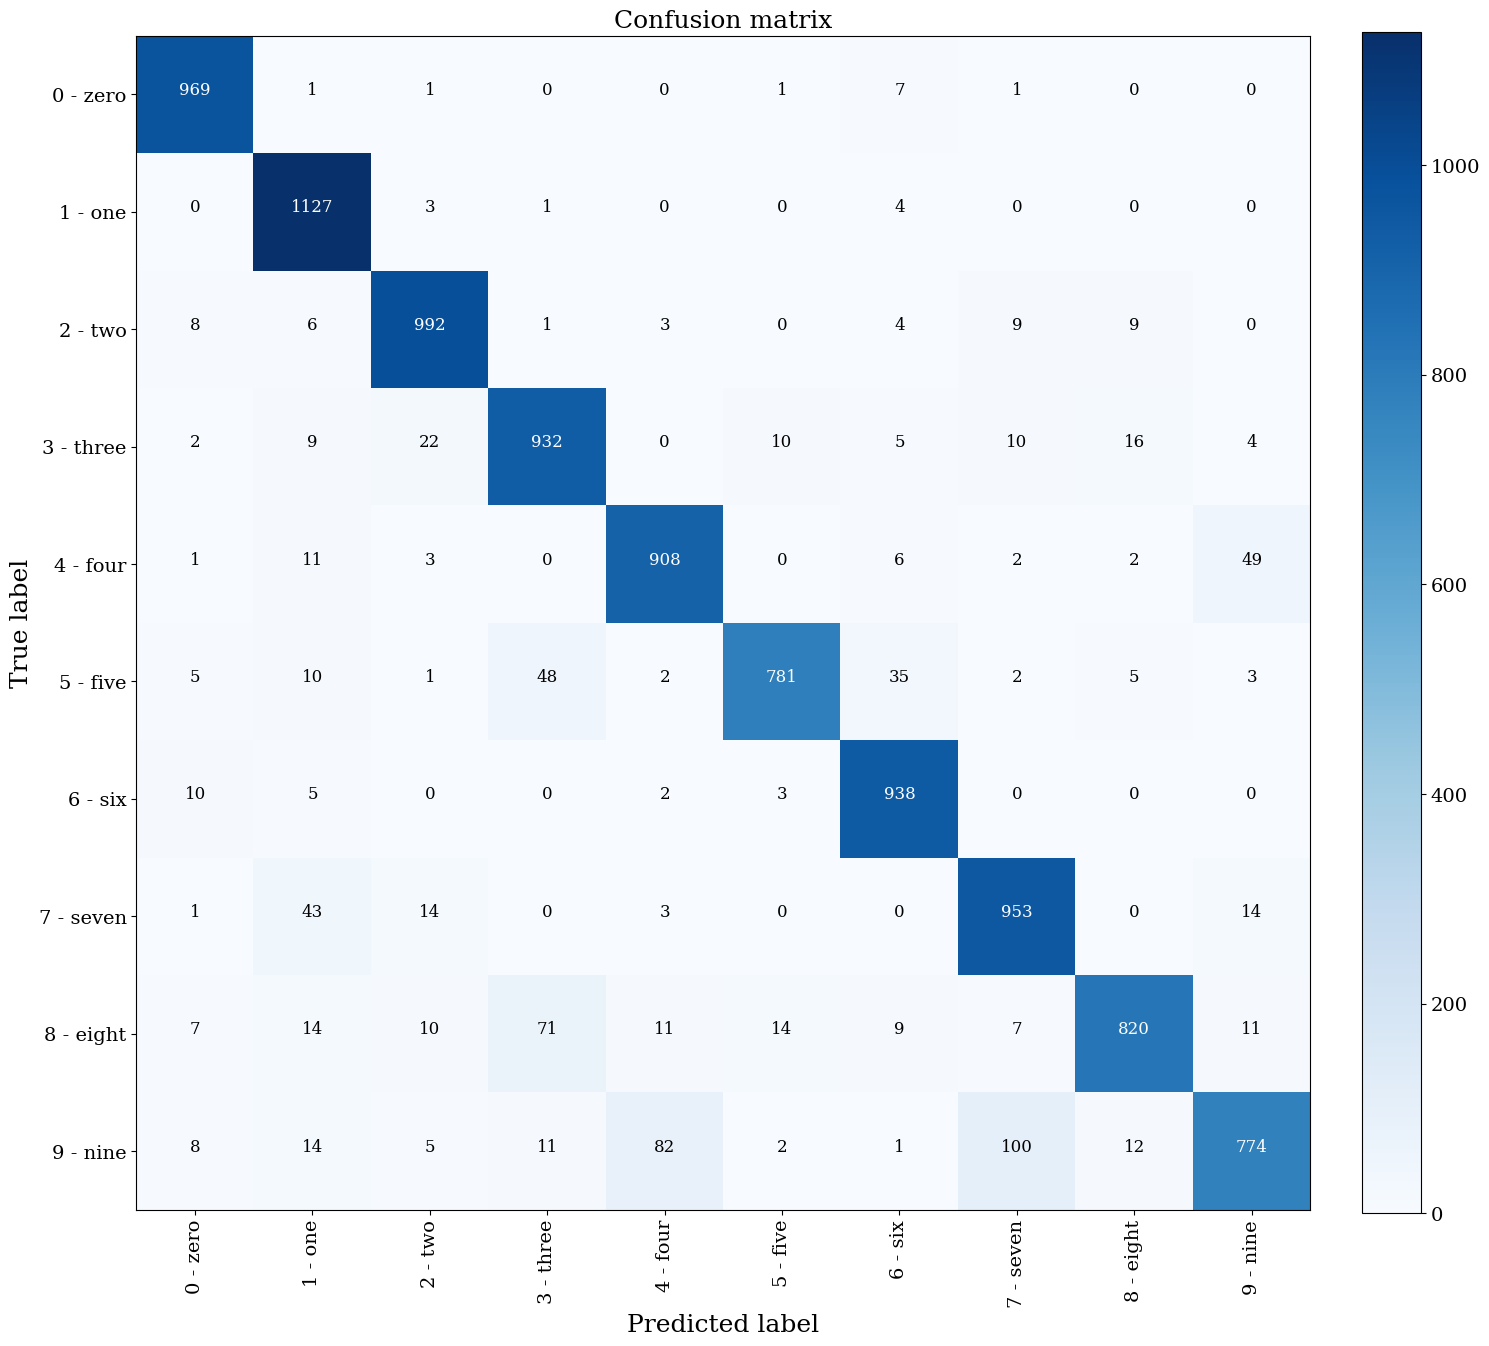

In [29]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
plot_confusion_matrix(cm, dl_val.dataset.classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, size=15)

## Modèle de base

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Définir l'architecture du réseau de neurones convolutif (CNN)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [14]:

import torch.nn as nn
import torch.optim as optim
# Instancier le modèle, la fonction de coût et l'optimiseur
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 500

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(dataloaders['label']):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloaders)}, Loss: {loss.item()}')

# Évaluation du modèle sur l'ensemble de test
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in dataloaders['test']:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = correct / total
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')


Epoch 1/500, Batch 0/4, Loss: 2.3066680431365967
Epoch 2/500, Batch 0/4, Loss: 2.243553638458252
Epoch 3/500, Batch 0/4, Loss: 2.1561920642852783
Epoch 4/500, Batch 0/4, Loss: 2.0273354053497314
Epoch 5/500, Batch 0/4, Loss: 1.838463544845581
Epoch 6/500, Batch 0/4, Loss: 1.5973633527755737
Epoch 7/500, Batch 0/4, Loss: 1.3812013864517212
Epoch 8/500, Batch 0/4, Loss: 1.114724040031433
Epoch 9/500, Batch 0/4, Loss: 0.9636144042015076
Epoch 10/500, Batch 0/4, Loss: 0.6627751588821411
Epoch 11/500, Batch 0/4, Loss: 0.667880654335022
Epoch 12/500, Batch 0/4, Loss: 0.458353191614151
Epoch 13/500, Batch 0/4, Loss: 0.47364673018455505
Epoch 14/500, Batch 0/4, Loss: 0.4034655690193176
Epoch 15/500, Batch 0/4, Loss: 0.247446209192276
Epoch 16/500, Batch 0/4, Loss: 0.19164176285266876
Epoch 17/500, Batch 0/4, Loss: 0.1840360015630722
Epoch 18/500, Batch 0/4, Loss: 0.147483691573143
Epoch 19/500, Batch 0/4, Loss: 0.1054106056690216
Epoch 20/500, Batch 0/4, Loss: 0.12291502952575684
Epoch 21/500,

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# ...

# Évaluation du modèle sur l'ensemble de test
model.eval()
correct = 0
total = 0
all_predicted = []
all_targets = []

with torch.no_grad():
    for data, target in dataloaders['test']:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Convertir les tensors PyTorch en listes numpy pour la matrice de confusion
        all_predicted.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(all_targets, all_predicted)
print("Matrice de confusion :\n", conf_matrix)


Accuracy on the test set: 78.73%
Matrice de confusion :
 [[ 916    2    1    6   10   13   15    1   12    4]
 [   0 1057    2    0    0    9    5    0   62    0]
 [  12   21  708  119   41   13   38   10   67    3]
 [   6   17   46  665    5   40   17   24  168   22]
 [   0    5    3    0  868    8   18    8    1   71]
 [  19    6    5   39   63  530   24   16  180   10]
 [  10   16    7    0   15   39  859    0   12    0]
 [   2   15    2   26   29    4    2  793   11  144]
 [  34   39    9   42    9  133   23   15  631   39]
 [   8    8    2   16   83    3    0   30   13  846]]


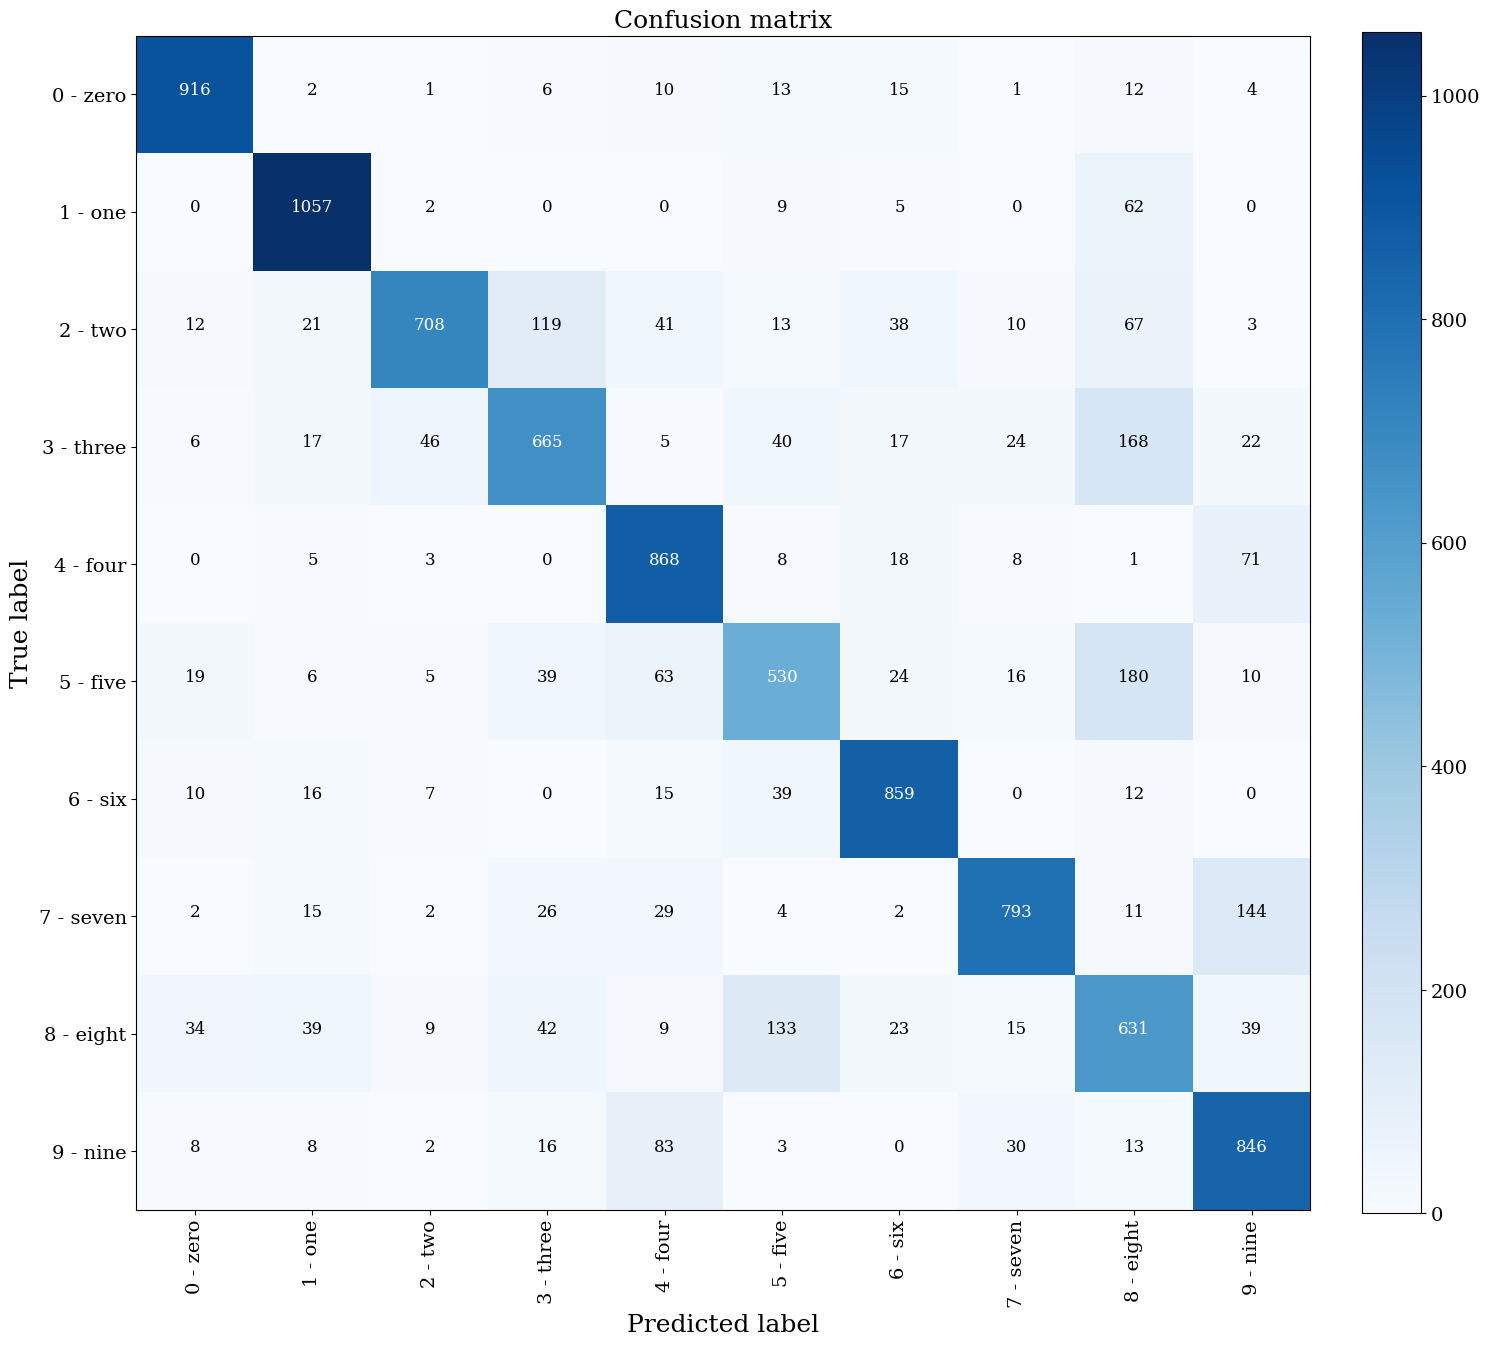

In [ ]:
plot_confusion_matrix(conf_matrix, dl_val.dataset.classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, size=15)